# 과제1_신용대출 심사_변수중요도

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다.

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


* 고객에게 제공한 예측 모델
    * 여러분은 다양한 알고리즘과 튜닝을 통해 모델을 생성하였습니다.
    * 모델의 정확도가 상당히 높다고 평가 되었습니다.
    * 고객은 여러분의 결과물에 대해 기뻐하고 있습니다. 그리고 한가지 질문을 해 왔습니다.
        * **"이번에 제공한 예측 모델의 정확도가 높아 상당히 만족스럽습니다. 그런데 궁금한 점이 있습니다. 모델이 신용도를 예측하는데 중요한 요인은 무엇인가요?"**

* 본 과제를 통해서 다음을 수행합니다.
    * 다양한 알고리즘으로 모델을 만들고 성능 평가하기
    * 트리 모델로 부터 변수 중요도 확인하기
    * 그 외 모델(SVM, DL 등) 변수 중요도 확인하기

## 1.환경준비

### 1) 라이브러리 로딩

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

### 2) 필요한 함수 생성

In [2]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수중요도, feature 이름 정리
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 전체? or top N?
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 정리한 변수 중요도 df return
    return fi_df

In [3]:
# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

### 3) 데이터 로딩

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.drop('Purpose', axis = 1, inplace = True)
data.head()

,Creditability,AccountBalance,Duration,Payment,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|



* 데이터의 크기를 살펴봅시다.

In [5]:
data.shape

(1000, 16)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


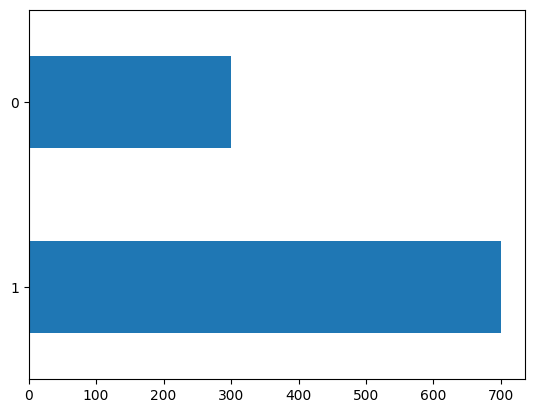

In [6]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts(normalize = True))

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기

In [7]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [8]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


### 3) train : validation 분할

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)

## 3.트리 모델의 변수 중요도
* 모델 생성
    * decision tree, random forest, xgb 알고리즘을 이용하여 각각 모델을 만드시오.
    * 모델을 튜닝하시오.
* 성능 및 변수 중요도 비교
    * 성능이 가장 좋은 모델을 선정하시오.
    * 성능이 가장 좋은 모델의 변수 중요도와 그렇지 않은 모델의 변수 중요도를 비교하시오.


### 1) decision tree

In [10]:
params = {'max_depth':range(1, 20)}

model1 = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
model1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20)})

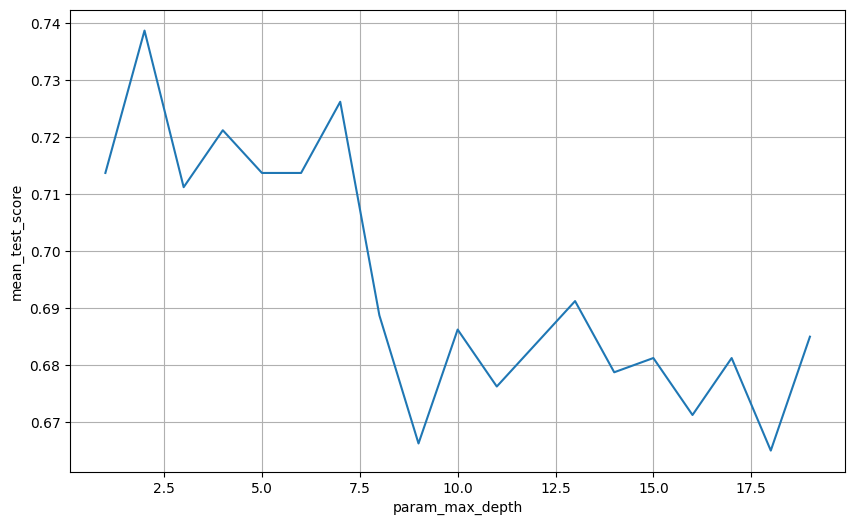

In [11]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model1.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

### 2) random forest

In [12]:
model2 = RandomForestClassifier()
model2.fit(x_train, y_train)

RandomForestClassifier()

### 3) xgboost

In [13]:
params = {'max_depth':range(2, 6), 'learning_rate':np.linspace(0.01, 0.4, 10)
            , 'n_estimators':[50, 100, 150]}

model3 = GridSearchCV(XGBClassifier(), params, cv = 5)
model3.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                         'max_depth': range(2, 6),
                         'n_estimators': [50, 100, 150]})

### 4) 모델 성능 비교
* 세 모델 중 성능이 가장 좋은 모델은?

In [14]:
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
pred3 = model3.predict(x_val)

In [15]:
print(confusion_matrix(y_val, pred1 ))
print(classification_report(y_val, pred1 ))

[[ 28  43]
 [ 22 107]]
              precision    recall  f1-score   support

           0       0.56      0.39      0.46        71
           1       0.71      0.83      0.77       129

    accuracy                           0.68       200
   macro avg       0.64      0.61      0.61       200
weighted avg       0.66      0.68      0.66       200



In [16]:
print(confusion_matrix(y_val, pred2 ))
print(classification_report(y_val, pred2 ))

[[ 26  45]
 [  8 121]]
              precision    recall  f1-score   support

           0       0.76      0.37      0.50        71
           1       0.73      0.94      0.82       129

    accuracy                           0.73       200
   macro avg       0.75      0.65      0.66       200
weighted avg       0.74      0.73      0.70       200



In [17]:
print(confusion_matrix(y_val, pred3 ))
print(classification_report(y_val, pred3 ))

[[ 32  39]
 [ 13 116]]
              precision    recall  f1-score   support

           0       0.71      0.45      0.55        71
           1       0.75      0.90      0.82       129

    accuracy                           0.74       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.74      0.74      0.72       200



* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다.

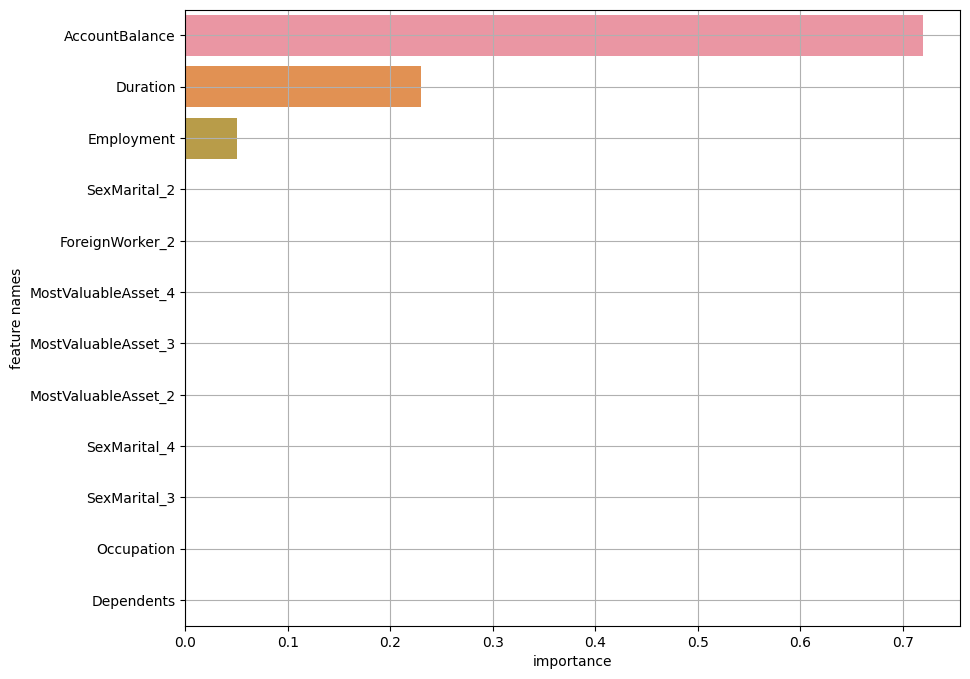

In [18]:
result1 = plot_feature_importance(model1.best_estimator_.feature_importances_, list(x),12)

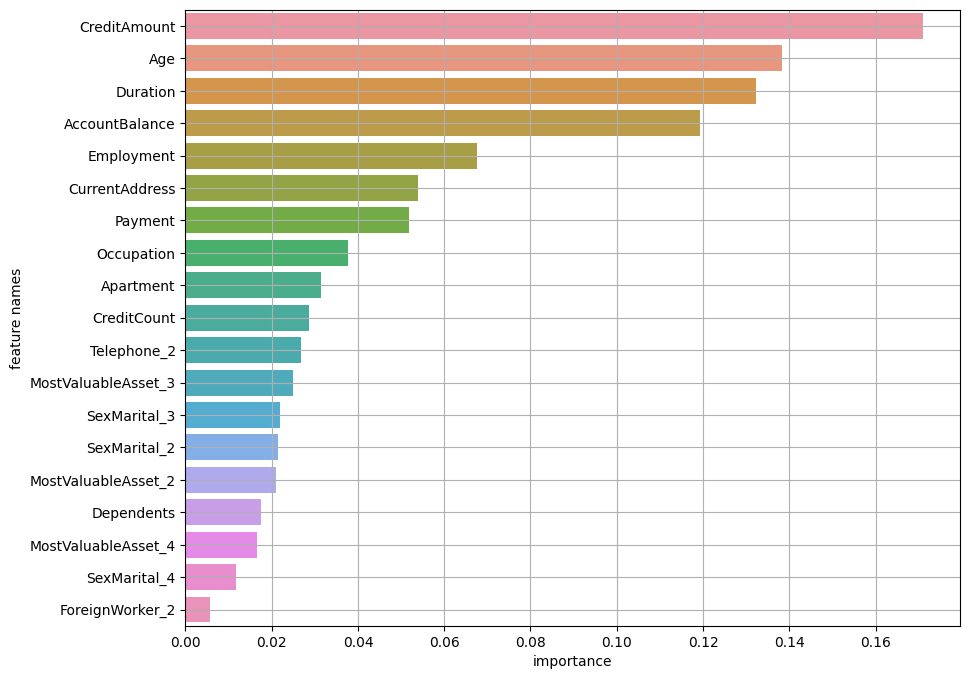

In [19]:
result2 = plot_feature_importance(model2.feature_importances_, list(x))

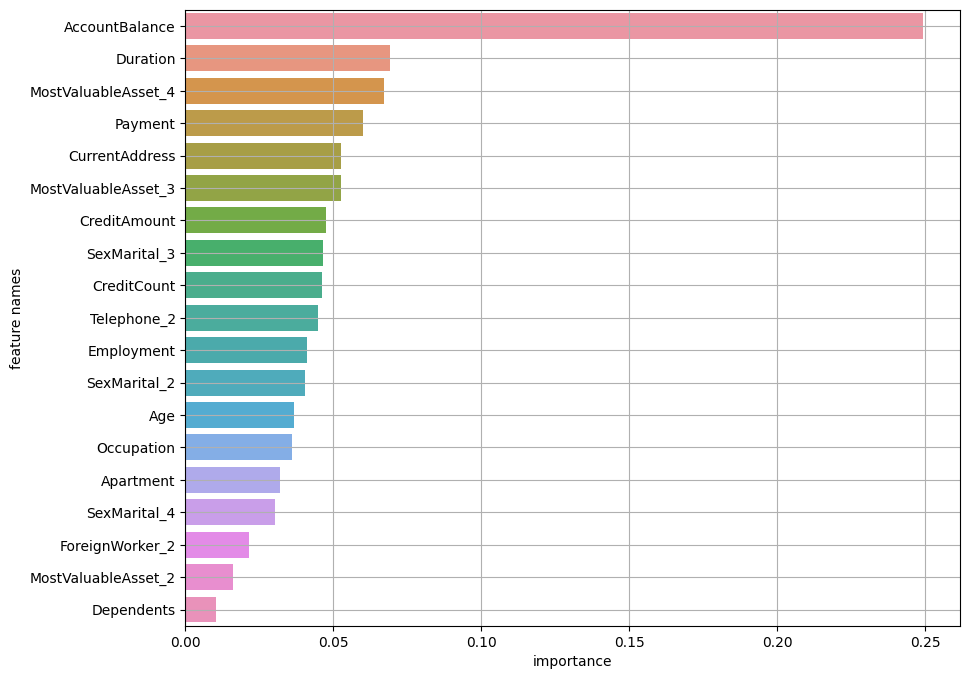

In [20]:
result3 = plot_feature_importance(model3.best_estimator_.feature_importances_, list(x))

## 4.Permutation Feature Importance
* 변수 중요도를 제공하지 않는 모델 생성
    * SVM, KNN, DL 혹은 그외 알고리즘으로 모델을 생성하시오.
    * 알고 있는 방법을 최대한 동원하여 모델을 각각 최적화 하시오.
* 성능 및 변수 중요도 비교
    * 트리 모델과 성능 비교
    * Permutation Feature Importance 를 이용하여 변수 중요도를 뽑아 봅시다.


In [21]:
from sklearn.inspection import permutation_importance

* 스케일링

In [22]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 1) 모델1

* svm

In [23]:
params = {'C':[0.1,0.5,1,2,5,10]}

model4 = GridSearchCV(SVC(), params, cv = 5)
model4.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 0.5, 1, 2, 5, 10]})

In [24]:
pfi1 = permutation_importance(model4, x_val_s, y_val, n_repeats=10, scoring = 'accuracy', random_state=20)

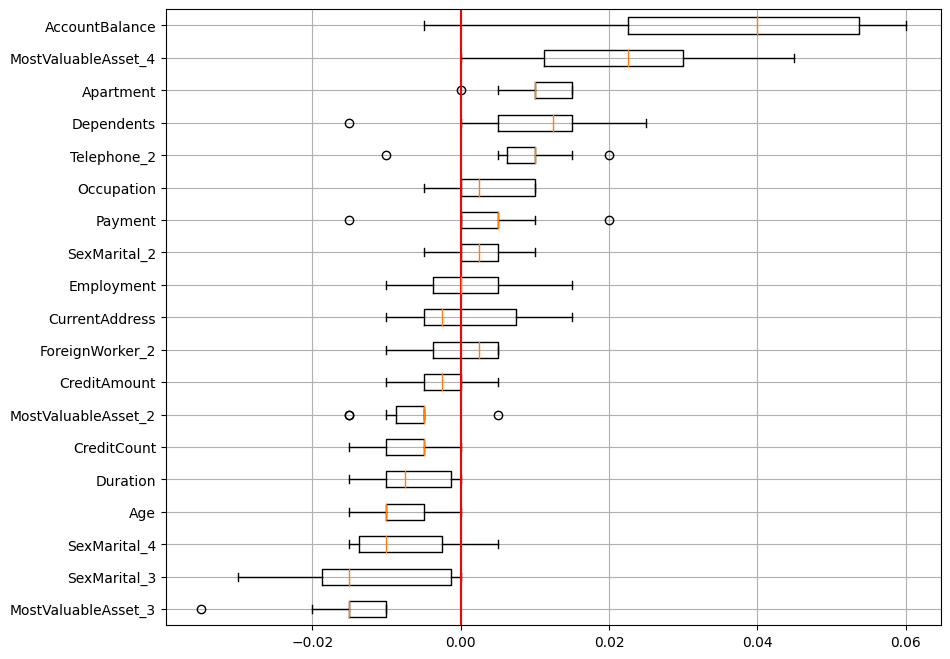

In [25]:
sorted_idx = pfi1.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

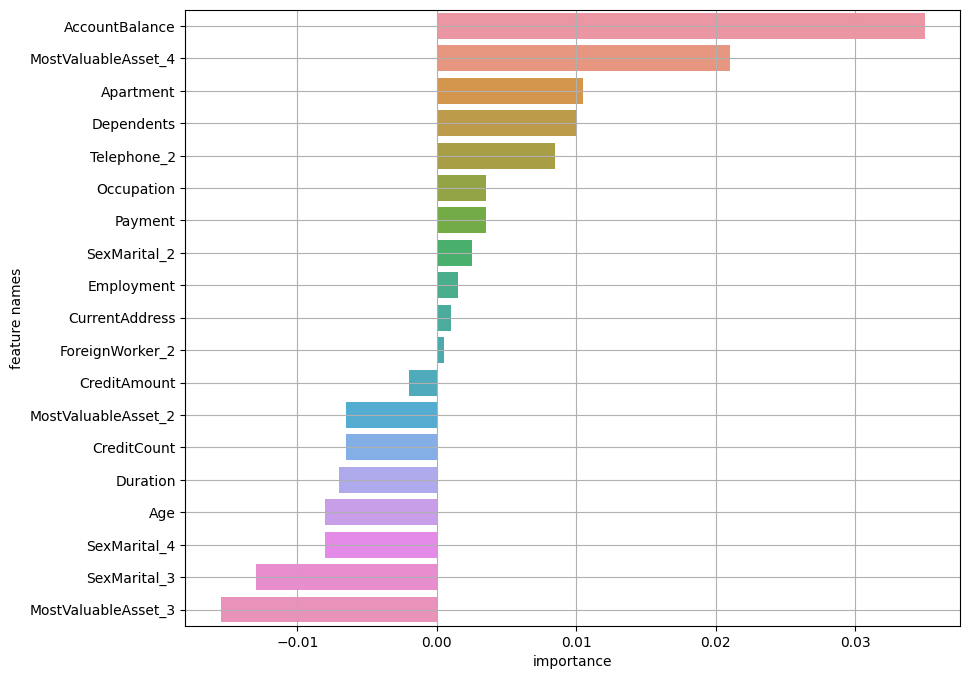

In [26]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

In [27]:
pred4 = model4.predict(x_val_s)
print(confusion_matrix(y_val, pred4 ))
print(classification_report(y_val, pred4 ))

[[ 19  52]
 [ 11 118]]
              precision    recall  f1-score   support

           0       0.63      0.27      0.38        71
           1       0.69      0.91      0.79       129

    accuracy                           0.69       200
   macro avg       0.66      0.59      0.58       200
weighted avg       0.67      0.69      0.64       200



### 2) 모델2
* DL

In [30]:
nfeatures = x_train_s.shape[1]
clear_session()

model5 = Sequential([Dense(32, input_shape = [nfeatures,], activation = 'swish'),
                     Dense(16, activation = 'swish'),
                     Dense(1, activation = 'sigmoid')
                     ])

model5.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy')
history = model5.fit(x_train_s, y_train, epochs = 50, validation_split = .2).history

Epoch 1/50
20/20 [==============================] - 1s 11ms/step - loss: 0.6372 - val_loss: 0.5948
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5942 - val_loss: 0.5661
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5809 - val_loss: 0.5573
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5726 - val_loss: 0.5516
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5634 - val_loss: 0.5448
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5544 - val_loss: 0.5384
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5458 - val_loss: 0.5323
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5370 - val_loss: 0.5252
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.5199
Epoch 10/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5210 - val_loss: 0.5167
Epoch 11/50
20/20 

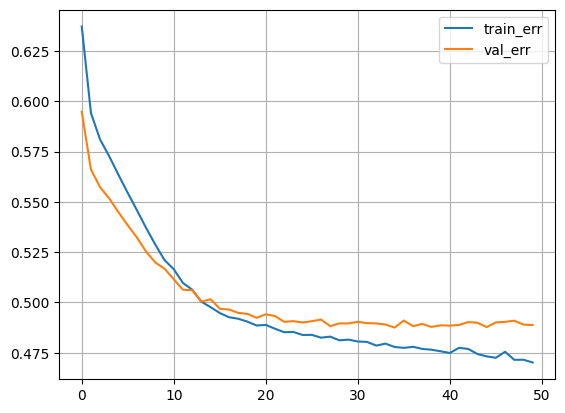

In [31]:
plt.plot(history['loss'], label = 'train_err')
plt.plot(history['val_loss'], label = 'val_err')
plt.grid()
plt.legend()
plt.show()

In [32]:
pfi2 = permutation_importance(model5, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=20)

7/7 [==============================] - 0s 2ms/step


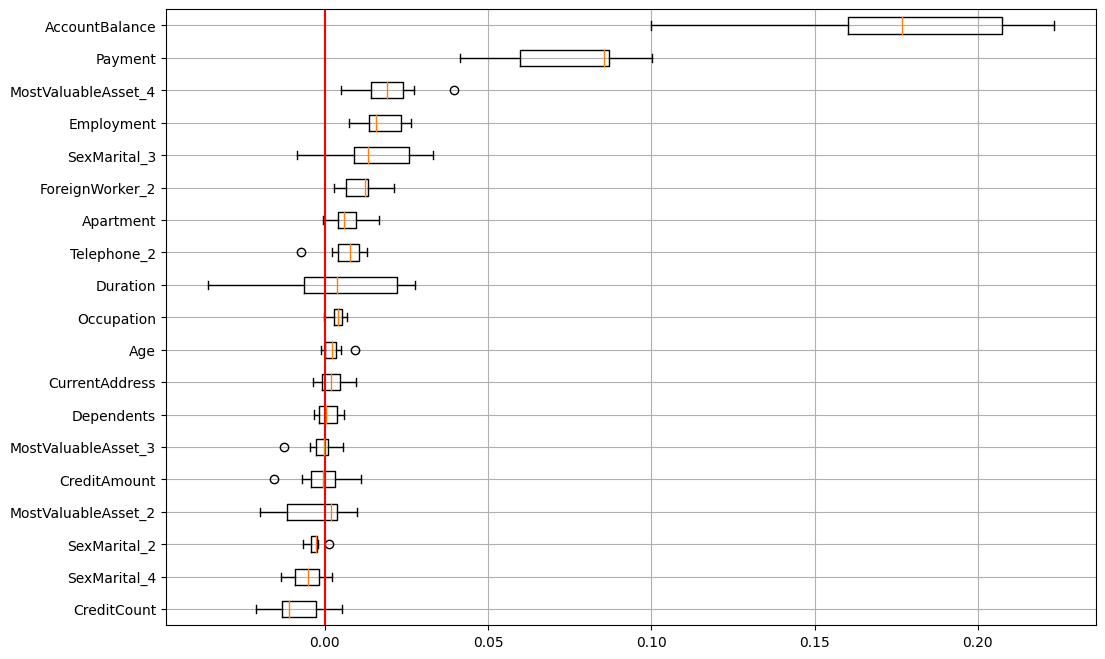

In [33]:
sorted_idx = pfi2.importances_mean.argsort()
plt.figure(figsize = (12,8))
plt.boxplot(pfi2.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

* 평균값으로 변수중요도 그래프 그리기

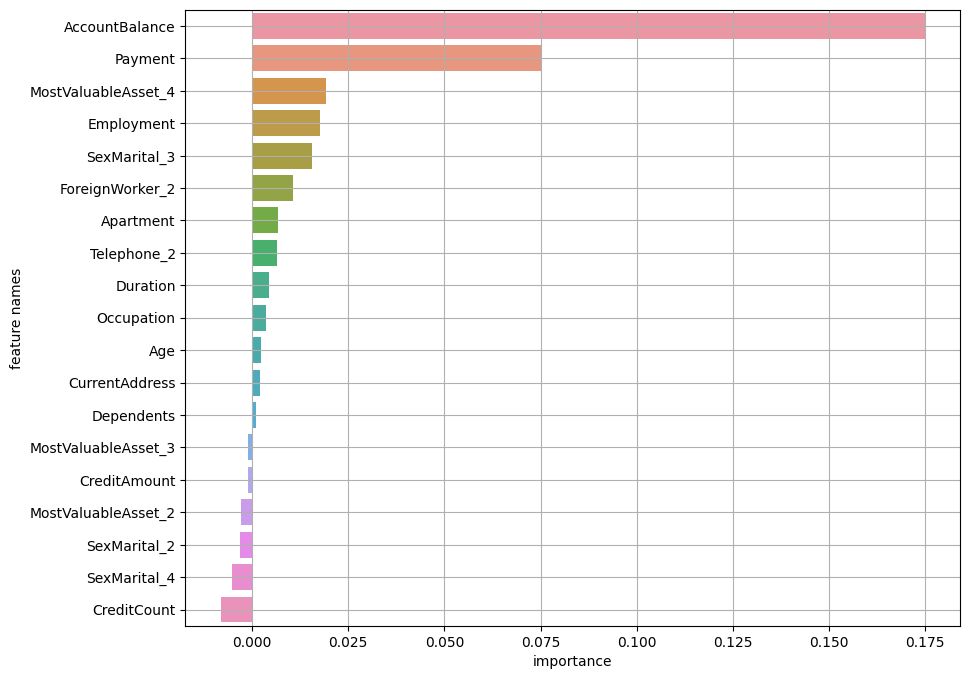

In [34]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

In [35]:
pred5 = model5.predict(x_val_s)
pred5 = np.where(pred5 >= .5, 1, 0)

print(confusion_matrix(y_val, pred5))
print(classification_report(y_val, pred5))

7/7 [==============================] - 0s 1ms/step
[[ 29  42]
 [ 18 111]]
              precision    recall  f1-score   support

           0       0.62      0.41      0.49        71
           1       0.73      0.86      0.79       129

    accuracy                           0.70       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.69      0.70      0.68       200



----

* 성능비교

In [36]:
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[ 28  43]
 [ 22 107]]
              precision    recall  f1-score   support

           0       0.56      0.39      0.46        71
           1       0.71      0.83      0.77       129

    accuracy                           0.68       200
   macro avg       0.64      0.61      0.61       200
weighted avg       0.66      0.68      0.66       200



In [37]:
print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

[[ 26  45]
 [  8 121]]
              precision    recall  f1-score   support

           0       0.76      0.37      0.50        71
           1       0.73      0.94      0.82       129

    accuracy                           0.73       200
   macro avg       0.75      0.65      0.66       200
weighted avg       0.74      0.73      0.70       200



In [38]:
print(confusion_matrix(y_val, pred3))
print(classification_report(y_val, pred3))

[[ 32  39]
 [ 13 116]]
              precision    recall  f1-score   support

           0       0.71      0.45      0.55        71
           1       0.75      0.90      0.82       129

    accuracy                           0.74       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.74      0.74      0.72       200



In [39]:
print(confusion_matrix(y_val, pred4))
print(classification_report(y_val, pred4))

[[ 19  52]
 [ 11 118]]
              precision    recall  f1-score   support

           0       0.63      0.27      0.38        71
           1       0.69      0.91      0.79       129

    accuracy                           0.69       200
   macro avg       0.66      0.59      0.58       200
weighted avg       0.67      0.69      0.64       200



In [40]:
print(confusion_matrix(y_val, pred5))
print(classification_report(y_val, pred5))

[[ 29  42]
 [ 18 111]]
              precision    recall  f1-score   support

           0       0.62      0.41      0.49        71
           1       0.73      0.86      0.79       129

    accuracy                           0.70       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.69      0.70      0.68       200



## 5.모델저장
* joblib을 이용하여 선정한 모델을 저장합니다.

In [41]:
import joblib

joblib.dump(model3, 'model.pkl')

['model.pkl']